In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd

from bokeh.io import output_notebook
output_notebook()
from bokeh.models import ColumnDataSource, Span
from bokeh.plotting import figure, show, output_file

from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

Loading BokehJS ...

In [2]:
customers = pd.read_csv('./data/customer_details.csv')
deliveries = pd.read_csv('./data/deliveries.csv')
colocations = pd.read_csv('./data/colocations.csv')


In [3]:
dataset = pd.read_csv('./data/level_readings.csv')

In [4]:
include = ['CNTRY_UN_COUNTRY_CODE', 'PROVINCE', 'PRD_ID', 'MKT_SEGMENT']
include_unchanged = ['MAXIMUM_PRODUCT_CAPACITY', 'VESSEL_ID']
one_hot_encoded_customers = pd.get_dummies(customers[include])
one_hot_encoded_customers = pd.concat([one_hot_encoded_customers, customers[include_unchanged]], axis=1)
one_hot_encoded_customers.head()

,CNTRY_UN_COUNTRY_CODE_AU,CNTRY_UN_COUNTRY_CODE_BR,CNTRY_UN_COUNTRY_CODE_CA,CNTRY_UN_COUNTRY_CODE_CN,CNTRY_UN_COUNTRY_CODE_GB,CNTRY_UN_COUNTRY_CODE_IE,CNTRY_UN_COUNTRY_CODE_IN,CNTRY_UN_COUNTRY_CODE_MY,CNTRY_UN_COUNTRY_CODE_NZ,CNTRY_UN_COUNTRY_CODE_TH,...,MKT_SEGMENT_Food & Beverage,MKT_SEGMENT_Food & beverage,MKT_SEGMENT_Healthcare,MKT_SEGMENT_Internal,MKT_SEGMENT_Manufacturing Industries,MKT_SEGMENT_Manufacturing Indutries,MKT_SEGMENT_Metals & Glass,MKT_SEGMENT_internal,MAXIMUM_PRODUCT_CAPACITY,VESSEL_ID
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2195,BR-216705
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13075,BR-216706
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,3567,BR-216721
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,13852,BR-216729
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2195,BR-216732


In [5]:
dataset.index = pd.to_datetime(dataset.ON_DATE_TIME, format='%Y-%m-%dT%H:%M:%S.%f')
dataset = dataset.drop(columns="ON_DATE_TIME")
dataset.head()

,COUNTRY_CODE,INST_ID,INST_PRODUCT_AMOUNT,VESSEL_ID
ON_DATE_TIME,,,,
2017-10-02 00:59:00,MY,62,13870,MY-62
2017-10-02 01:59:00,MY,62,18330,MY-62
2017-10-02 02:59:00,MY,62,15367,MY-62
2017-10-02 03:59:00,MY,62,13805,MY-62
2017-10-02 04:59:00,MY,62,27870,MY-62


In [6]:
deliveries.index = pd.to_datetime(deliveries.DELIVERY_DATE, format='%m/%d/%Y %H:%M')
deliveries = deliveries.drop(columns="DELIVERY_DATE")
deliveries.head()

,DELIVERED_VOLUME,VESSEL_ID
DELIVERY_DATE,,
2016-03-13 01:34:00,12362,UK-3749
2016-03-13 02:18:00,11564,UK-3806
2016-03-13 06:48:00,3103,UK-41488
2016-03-13 07:07:00,3683,UK-63168
2016-03-13 07:24:00,6545,UK-2435


In [7]:
list_of_vessel_ids = deliveries.VESSEL_ID.unique().copy()
list_of_vessel_ids[:4]

array(['UK-3749', 'UK-3806', 'UK-41488', 'UK-63168'], dtype=object)

In [8]:
copy_of_vessel_ids = list_of_vessel_ids.copy()
# np.random.seed(42)
np.random.shuffle(copy_of_vessel_ids)
test_id = copy_of_vessel_ids[0]
test_data = dataset[dataset.VESSEL_ID == test_id]
copy_of_vessel_ids = copy_of_vessel_ids[1:]

print(f"Test Vessel: {test_id}")

Test Vessel: SP-56953


In [9]:
training_id, validate_id = np.random.choice(copy_of_vessel_ids, 2, replace=False)
print(f"Training Vessel: {training_id}")
print(f"Validation Vessel: {validate_id}")

Training Vessel: SP-202
Validation Vessel: CN-152179


In [26]:
training_data = dataset[dataset.VESSEL_ID == training_id]
training_data.head()

,COUNTRY_CODE,INST_ID,INST_PRODUCT_AMOUNT,VESSEL_ID
ON_DATE_TIME,,,,
2016-03-16 23:00:00,SP,202,12027,SP-202
2016-03-17 00:00:00,SP,202,12004,SP-202
2016-03-17 01:00:00,SP,202,11996,SP-202
2016-03-17 02:00:00,SP,202,11973,SP-202
2016-03-17 03:00:00,SP,202,11939,SP-202


In [27]:
validate_data = dataset[dataset.VESSEL_ID == validate_id]
validate_data.head()

,COUNTRY_CODE,INST_ID,INST_PRODUCT_AMOUNT,VESSEL_ID
ON_DATE_TIME,,,,
2017-11-11 05:59:00,CN,152179,16614,CN-152179
2017-11-11 06:59:00,CN,152179,16535,CN-152179
2017-11-11 07:59:00,CN,152179,16379,CN-152179
2017-11-07 14:59:00,CN,152179,16358,CN-152179
2017-11-07 15:59:00,CN,152179,16096,CN-152179


In [12]:
# copy_td = training_data.copy()
# copy_td = copy_td[:]

# divide = int(len(copy_td)*0.6)
# column_slice = ["INST_PRODUCT_AMOUNT"]
# raw_data = copy_td[column_slice]
# raw_data = np.squeeze(raw_data)
# train, test = copy_td[:divide][column_slice], copy_td[divide:][column_slice]
# print(raw_data.shape)
# print(train.shape)
# print(test.shape)

In [13]:
# a_list = list(np.array(test.INST_PRODUCT_AMOUNT))
# for item, value in enumerate(a_list):
#     print(f"No.: {item}")
#     print(f"Original: {test.iloc[item].date}")
#     print(f"A List: {a_list[item]}")
#     print(f"Original: {test.iloc[item].INST_PRODUCT_AMOUNT}")

In [14]:

# walk-forward validation

# history = list(np.array(train.INST_PRODUCT_AMOUNT))
# test_set = np.array(test.INST_PRODUCT_AMOUNT)
# predictions = list()
# for i in range(len(test_set)):
#     # make prediction
#     predictions.append(history[-1])
#     # observation
#     history.append(test_set[i])
# # report performance
# rmse = sqrt(mean_squared_error(test_set, predictions))
# print('RMSE: %.3f' % rmse)
# # line plot of observed vs predicted
# pyplot.plot(np.array(test.INST_PRODUCT_AMOUNT))
# pyplot.plot(predictions)
# pyplot.show()

In [15]:
# from sklearn.preprocessing import MinMaxScaler
# scaled_data = training_data.copy()
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = scaler.fit(scaled_data.INST_PRODUCT_AMOUNT.values.reshape(-1, 1))
# scaled_data["scaled"] = scaler.transform(scaled_data.INST_PRODUCT_AMOUNT.values.reshape(-1, 1))
# scaled_data[50:60].head()

In [312]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    print("Scaler2,", train.shape)
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    print(X.shape)
    print(value)
    new_row = X[0].tolist() + [value]
    print(new_row)    
    array = numpy.array(new_row)
    print(array.shape)    
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    print(train.shape)
    print(len(train))
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    print(X.shape)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        print(X[0].shape)
        model.fit(X, y, epochs=1, batch_size=batch_size,  shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
#     X = X.reshape(1, 1, X)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [313]:
# supervised = timeseries_to_supervised(training_data, 1)
# supervised.head()


In [314]:
# # fit the model
# lstm_model = fit_lstm(train_scaled, batch_size, 1, 4)
# # forecast the entire training dataset to build up state for forecasting
# train_reshaped = train_scaled[:, -1].reshape(len(train_scaled), 1, 10)
# print(train_reshaped)
# state = lstm_model.predict(train_reshaped, batch_size=batch_size)

In [315]:
batch_size = 18
lag = 10

copy_td = training_data[:].copy()
column_slice = ["INST_PRODUCT_AMOUNT"]
series = copy_td[:][column_slice]
print(copy_td.head())

raw_values = series.values
diff_values = difference(raw_values, 1)

print(f"Raw: {raw_values.shape}")
print(f"Diff: {diff_values.shape}")

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag)
supervised_values = supervised.values

print(supervised.head())
print(f"Supervised: {supervised.shape}")
print(f"Supervised values: {supervised_values.shape}")

test_data_percent = 0.25
test_data_num = int(supervised_values.shape[0] * test_data_percent)

# split data into train and test-sets
train, test = supervised_values[0:-test_data_num], supervised_values[-test_data_num:]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print(batches)
batches = len(train_scaled)//batch_size
train_scaled = train_scaled[:batches*batch_size]

print(f"Scaler returned shape {train_scaled.shape} for training data")
print(f"Scaler returned shape {test_scaled.shape} for test data")

print(train_scaled[0])

                    COUNTRY_CODE  INST_ID  INST_PRODUCT_AMOUNT VESSEL_ID
ON_DATE_TIME                                                            
2016-03-16 23:00:00           SP      202                12027    SP-202
2016-03-17 00:00:00           SP      202                12004    SP-202
2016-03-17 01:00:00           SP      202                11996    SP-202
2016-03-17 02:00:00           SP      202                11973    SP-202
2016-03-17 03:00:00           SP      202                11939    SP-202
Raw: (17183, 1)
Diff: (17182,)
       0      0      0      0  0  0  0  0  0  0      0
0      0      0      0      0  0  0  0  0  0  0  [-23]
1  [-23]      0      0      0  0  0  0  0  0  0   [-8]
2   [-8]  [-23]      0      0  0  0  0  0  0  0  [-23]
3  [-23]   [-8]  [-23]      0  0  0  0  0  0  0  [-34]
4  [-34]  [-23]   [-8]  [-23]  0  0  0  0  0  0    [0]
Supervised: (17182, 11)
Supervised values: (17182, 11)
train: (12887, 11)
test: (4295, 11)
Scaler2, (12887, 11)
715
Scaler retur

/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [316]:
print(train_scaled.shape)
print(len(train_scaled))
train_reshaped = train_scaled[:, :-1].reshape(len(train_scaled), 1, lag)
print(train_reshaped.shape)

state = lstm_model.predict(train_reshaped, batch_size=batch_size)
state.shape

(12870, 11)
12870
(12870, 1, 10)


(12870, 1)

In [317]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
print(test_scaled.shape)
# print(raw_values)
test_reshaped = test_scaled[:,:-1].reshape(len(test_scaled), 1, 10)
print(test_reshaped.shape)
train_e, test_e = raw_values[0:-test_data_num], raw_values[-test_data_num:]

print("bacthes", len(test_scaled)//batch_size)

for i in range(len(test_scaled)//batch_size):
    # make one-step forecast
    print("I", i)
    print(f"Batch from {start} to {end}")

    start= i*batch_size
    end = start + batch_size
    print("Something", test_reshaped[start:end].shape)
    X = test_reshaped[start:end].reshape(batch_size,1,lag)
#     print(X.shape)X.reshape(1,1,18)
#     print(len())
    yhat = forecast_lstm(lstm_model, batch_size, X)
    predictions.append(yhat)
    # invert scaling
    yhat = invert_scale(scaler, X[0,:,:], yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = test_e[i]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

(4295, 11)
(4295, 1, 10)
bacthes 238
I 0
Batch from 4266 to 4284
Something (18, 1, 10)
(1, 10)
-0.5497214
[-0.5498489425981873, -0.5525146614537053, -0.5534032344055446, -0.54878265505598, -0.5486049404656121, -0.5498489425981873, -0.5473609383330371, -0.5484272258752443, -0.5429180735738404, -0.5493157988270837, -0.5497214]
(11,)
Month=1, Predicted=9333.717571, Expected=9318.000000
I 1
Batch from 0 to 18
Something (18, 1, 10)
(1, 10)
-0.54866016
[-0.5414963568508974, -0.5718855518038031, -0.5494935134174516, -0.5388306379953793, -0.5377643504531722, -0.5555358094899591, -0.5503820863692909, -0.5443397902967834, -0.5670872578638706, -0.5322551981517682, -0.54866016]
(11,)
Month=2, Predicted=9313.689285, Expected=9339.000000
I 2
Batch from 18 to 36
Something (18, 1, 10)
(1, 10)
-0.5487193
[-0.5493157988270837, -0.5500266571885551, -0.5473609383330371, -0.5512706593211302, -0.5530478052248089, -0.5550026657188555, -0.5530478052248089, -0.5397192109472188, -0.5478940821041407, -0.55020437

Something (18, 1, 10)
(1, 10)
-0.5490868
[-0.5519815176826017, -0.5443397902967834, -0.5546472365381198, -0.5455837924293584, -0.5535809489959125, -0.54878265505598, -0.5496712280078194, -0.550204371778923, -0.5496712280078194, -0.5455837924293584, -0.5490868]
(11,)
Month=55, Predicted=8815.288525, Expected=8833.000000
I 55
Batch from 972 to 990
Something (18, 1, 10)
(1, 10)
-0.5172484
[-0.5509152301403945, -0.5503820863692909, -0.551448373911498, -0.5493157988270837, 0.1117824773413898, -0.5493157988270837, -0.5560689532610626, -0.5498489425981873, -0.5519815176826017, -0.5452283632486227, -0.5172484]
(11,)
Month=56, Predicted=9005.443298, Expected=8794.000000
I 56
Batch from 990 to 1008
Something (18, 1, 10)
(1, 10)
-0.51598287
[-0.5493157988270837, -0.5507375155500266, -0.5500266571885551, -0.5498489425981873, -0.5510929447307623, -0.5493157988270837, -0.54878265505598, -0.551626088501866, -0.5478940821041407, -0.5523369468633375, -0.51598287]
(11,)
Month=57, Predicted=8973.564411, 

In [310]:
# report performance
print(test_e.shape)
print(np.shape(predictions))
rmse = sqrt(mean_squared_error(test_e, predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-test_data_num:])
pyplot.plot(predictions)
pyplot.show()

(4295, 1)
(238,)


ValueError: Found input variables with inconsistent numbers of samples: [4295, 238]

In [311]:
copy_td = validate_data.copy()
column_slice = ["INST_PRODUCT_AMOUNT"]
series = copy_td[:][column_slice]
print(copy_td.head())

raw_values = series.values
diff_values = difference(raw_values, 1)

print(f"Raw: {raw_values.shape}")
print(f"Diff: {diff_values.shape}")

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

print(supervised.head())
print(f"Supervised: {supervised.shape}")
print(f"Supervised values: {supervised_values.shape}")

test_data_percent = 0.75
test_data_num = int(supervised_values.shape[0] * test_data_percent)

# split data into train and test-sets
train, test = supervised_values[0:-test_data_num], supervised_values[-test_data_num:]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

print(f"Scaler returned shape {train_scaled.shape} for training data")
print(f"Scaler returned shape {test_scaled.shape} for test data")

# fit the model
# lstm_model = fit_lstm(train_scaled, 1, 3, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))



                    COUNTRY_CODE  INST_ID  INST_PRODUCT_AMOUNT  VESSEL_ID
ON_DATE_TIME                                                             
2017-11-11 05:59:00           CN   152179                16614  CN-152179
2017-11-11 06:59:00           CN   152179                16535  CN-152179
2017-11-11 07:59:00           CN   152179                16379  CN-152179
2017-11-07 14:59:00           CN   152179                16358  CN-152179
2017-11-07 15:59:00           CN   152179                16096  CN-152179
Raw: (9014, 1)
Diff: (9013,)
        0       0
0       0   [-79]
1   [-79]  [-156]
2  [-156]   [-21]
3   [-21]  [-262]
4  [-262]    [-7]
Supervised: (9013, 2)
Supervised values: (9013, 2)
train: (2254, 2)
test: (6759, 2)
Scaler2, (2254, 2)
Scaler returned shape (2254, 2) for training data
Scaler returned shape (6759, 2) for test data


/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


ValueError: Error when checking : expected lstm_37_input to have shape (18, 1, 10) but got array with shape (2254, 1, 1)

Test RMSE: 513.382


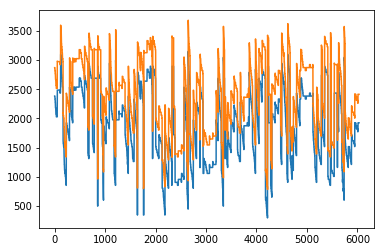

In [52]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-test_data_num:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-test_data_num:])
pyplot.plot(predictions)
pyplot.show()

In [53]:
copy_td = test_data.copy()
column_slice = ["INST_PRODUCT_AMOUNT"]
series = copy_td[:][column_slice]
print(copy_td.head())

raw_values = series.values
diff_values = difference(raw_values, 1)

print(f"Raw: {raw_values.shape}")
print(f"Diff: {diff_values.shape}")

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

print(supervised.head())
print(f"Supervised: {supervised.shape}")
print(f"Supervised values: {supervised_values.shape}")

test_data_percent = 0.75
test_data_num = int(supervised_values.shape[0] * test_data_percent)

# split data into train and test-sets
train, test = supervised_values[0:-test_data_num], supervised_values[-test_data_num:]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

print(f"Scaler returned shape {train_scaled.shape} for training data")
print(f"Scaler returned shape {test_scaled.shape} for test data")

# fit the model
# lstm_model = fit_lstm(train_scaled, 1, 3, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))



                    COUNTRY_CODE  INST_ID  INST_PRODUCT_AMOUNT  VESSEL_ID
ON_DATE_TIME                                                             
2018-02-17 06:59:00           BR   217283                 1408  BR-217283
2018-02-17 07:59:00           BR   217283                 1408  BR-217283
2018-02-17 08:59:00           BR   217283                 1408  BR-217283
2018-02-17 09:59:00           BR   217283                 1404  BR-217283
2018-02-17 10:59:00           BR   217283                 1400  BR-217283
Raw: (5680, 1)
Diff: (5679,)
      0     0
0     0   [0]
1   [0]   [0]
2   [0]  [-4]
3  [-4]  [-4]
4  [-4]  [-8]
Supervised: (5679, 2)
Supervised values: (5679, 2)
train: (1420, 2)
test: (4259, 2)
Scaler returned shape (1420, 2) for training data
Scaler returned shape (4259, 2) for test data


/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Month=1, Predicted=1997.789168, Expected=1260.000000
Month=2, Predicted=1997.827219, Expected=1256.000000
Month=3, Predicted=1993.770071, Expected=1260.000000
Month=4, Predicted=1997.870753, Expected=1251.000000
Month=5, Predicted=1988.713869, Expected=1280.000000
Month=6, Predicted=2018.300620, Expected=1292.000000
Month=7, Predicted=2030.508891, Expected=1288.000000
Month=8, Predicted=2026.313373, Expected=1251.000000
Month=9, Predicted=1988.473935, Expected=4036.000000
Month=10, Predicted=4824.286054, Expected=3843.000000
Month=11, Predicted=4617.647091, Expected=3819.000000
Month=12, Predicted=4583.663654, Expected=3771.000000
Month=13, Predicted=4527.160579, Expected=3722.000000
Month=14, Predicted=4471.545728, Expected=3674.000000
Month=15, Predicted=4418.674890, Expected=3662.000000
Month=16, Predicted=4403.883879, Expected=3646.000000
Month=17, Predicted=4385.997769, Expected=3638.000000
Month=18, Predicted=4376.896508, Expected=3626.000000
Month=19, Predicted=4364.139368, Expe

Month=303, Predicted=3787.571798, Expected=3050.000000
Month=304, Predicted=3787.643754, Expected=3050.000000
Month=305, Predicted=3787.711588, Expected=3046.000000
Month=306, Predicted=3783.686704, Expected=3038.000000
Month=307, Predicted=3775.579270, Expected=3042.000000
Month=308, Predicted=3779.719623, Expected=3038.000000
Month=309, Predicted=3775.701155, Expected=3034.000000
Month=310, Predicted=3771.668274, Expected=3034.000000
Month=311, Predicted=3771.719306, Expected=3030.000000
Month=312, Predicted=3767.690203, Expected=3026.000000
Month=313, Predicted=3763.658243, Expected=3030.000000
Month=314, Predicted=3767.788792, Expected=3030.000000
Month=315, Predicted=3767.830498, Expected=3026.000000
Month=316, Predicted=3763.774445, Expected=3026.000000
Month=317, Predicted=3763.797288, Expected=3022.000000
Month=318, Predicted=3759.745660, Expected=3022.000000
Month=319, Predicted=3759.774367, Expected=3022.000000
Month=320, Predicted=3759.806055, Expected=3018.000000
Month=321,

Month=606, Predicted=1832.457359, Expected=1095.000000
Month=607, Predicted=1832.582607, Expected=1091.000000
Month=608, Predicted=1828.603551, Expected=1086.000000
Month=609, Predicted=1823.585212, Expected=1086.000000
Month=610, Predicted=1823.661587, Expected=1082.000000
Month=611, Predicted=1819.652139, Expected=1082.000000
Month=612, Predicted=1819.711484, Expected=1074.000000
Month=613, Predicted=1811.609299, Expected=1074.000000
Month=614, Predicted=1811.666188, Expected=1070.000000
Month=615, Predicted=1807.650785, Expected=1046.000000
Month=616, Predicted=1783.241518, Expected=1006.000000
Month=617, Predicted=1742.568918, Expected=982.000000
Month=618, Predicted=1718.330177, Expected=978.000000
Month=619, Predicted=1714.589376, Expected=966.000000
Month=620, Predicted=1702.697653, Expected=950.000000
Month=621, Predicted=1686.691147, Expected=938.000000
Month=622, Predicted=1674.753525, Expected=934.000000
Month=623, Predicted=1670.965237, Expected=930.000000
Month=624, Predic

Month=910, Predicted=2839.464982, Expected=2101.000000
Month=911, Predicted=2839.369776, Expected=2101.000000
Month=912, Predicted=2839.247470, Expected=2097.000000
Month=913, Predicted=2835.069356, Expected=2097.000000
Month=914, Predicted=2835.000693, Expected=0.000000
Month=915, Predicted=699.534075, Expected=2093.000000
Month=916, Predicted=2833.357274, Expected=2093.000000
Month=917, Predicted=2836.668886, Expected=2084.000000
Month=918, Predicted=2826.485599, Expected=2080.000000
Month=919, Predicted=2821.354102, Expected=2080.000000
Month=920, Predicted=2820.449746, Expected=2076.000000
Month=921, Predicted=2815.652734, Expected=2072.000000
Month=922, Predicted=2811.035921, Expected=2068.000000
Month=923, Predicted=2806.581534, Expected=2068.000000
Month=924, Predicted=2806.333798, Expected=2068.000000
Month=925, Predicted=2806.174931, Expected=2060.000000
Month=926, Predicted=2797.915077, Expected=2056.000000
Month=927, Predicted=2793.786809, Expected=2056.000000
Month=928, Pre

Month=1212, Predicted=4559.788959, Expected=3754.000000
Month=1213, Predicted=4504.058871, Expected=3722.000000
Month=1214, Predicted=4467.345636, Expected=3714.000000
Month=1215, Predicted=4456.483377, Expected=3706.000000
Month=1216, Predicted=4446.592050, Expected=3702.000000
Month=1217, Predicted=4441.418853, Expected=3698.000000
Month=1218, Predicted=4436.675762, Expected=3694.000000
Month=1219, Predicted=4432.210338, Expected=3686.000000
Month=1220, Predicted=4423.847541, Expected=3686.000000
Month=1221, Predicted=4423.763494, Expected=3686.000000
Month=1222, Predicted=4423.751168, Expected=3682.000000
Month=1223, Predicted=4419.685518, Expected=3682.000000
Month=1224, Predicted=4419.715165, Expected=3682.000000
Month=1225, Predicted=4419.754331, Expected=3678.000000
Month=1226, Predicted=4415.710849, Expected=3678.000000
Month=1227, Predicted=4415.747203, Expected=3678.000000
Month=1228, Predicted=4415.785481, Expected=3678.000000
Month=1229, Predicted=4415.815542, Expected=3674

Month=1515, Predicted=2705.728942, Expected=1972.000000
Month=1516, Predicted=2709.849161, Expected=1968.000000
Month=1517, Predicted=2705.796717, Expected=1968.000000
Month=1518, Predicted=2705.814136, Expected=1968.000000
Month=1519, Predicted=2705.835585, Expected=1980.000000
Month=1520, Predicted=2718.085025, Expected=2012.000000
Month=1521, Predicted=2750.692079, Expected=2020.000000
Month=1522, Predicted=2758.733739, Expected=2024.000000
Month=1523, Predicted=2762.620752, Expected=2016.000000
Month=1524, Predicted=2754.279203, Expected=2016.000000
Month=1525, Predicted=2754.139990, Expected=2016.000000
Month=1526, Predicted=2754.055100, Expected=2008.000000
Month=1527, Predicted=2745.841573, Expected=2000.000000
Month=1528, Predicted=2737.664542, Expected=1988.000000
Month=1529, Predicted=2725.457067, Expected=1948.000000
Month=1530, Predicted=2684.751943, Expected=1948.000000
Month=1531, Predicted=2684.929234, Expected=1944.000000
Month=1532, Predicted=2681.097186, Expected=1940

Month=1818, Predicted=3071.761524, Expected=2322.000000
Month=1819, Predicted=3059.566698, Expected=2326.000000
Month=1820, Predicted=3063.698861, Expected=2322.000000
Month=1821, Predicted=3059.683749, Expected=2322.000000
Month=1822, Predicted=3059.732363, Expected=2318.000000
Month=1823, Predicted=3055.700429, Expected=2318.000000
Month=1824, Predicted=3055.743561, Expected=2314.000000
Month=1825, Predicted=3051.707803, Expected=2310.000000
Month=1826, Predicted=3047.670633, Expected=2310.000000
Month=1827, Predicted=3047.719571, Expected=2310.000000
Month=1828, Predicted=3047.767265, Expected=2306.000000
Month=1829, Predicted=3043.726272, Expected=2306.000000
Month=1830, Predicted=3043.762068, Expected=2302.000000
Month=1831, Predicted=3039.720686, Expected=2302.000000
Month=1832, Predicted=3039.757104, Expected=2298.000000
Month=1833, Predicted=3035.716675, Expected=2298.000000
Month=1834, Predicted=3035.754046, Expected=2294.000000
Month=1835, Predicted=3031.714420, Expected=2298

Month=2122, Predicted=1849.075888, Expected=1086.000000
Month=2123, Predicted=1823.504618, Expected=1054.000000
Month=2124, Predicted=1790.895304, Expected=1034.000000
Month=2125, Predicted=1770.656439, Expected=1030.000000
Month=2126, Predicted=1766.832317, Expected=1026.000000
Month=2127, Predicted=1763.023844, Expected=1022.000000
Month=2128, Predicted=1759.179574, Expected=1018.000000
Month=2129, Predicted=1755.298803, Expected=1018.000000
Month=2130, Predicted=1755.464137, Expected=1014.000000
Month=2131, Predicted=1751.517780, Expected=1006.000000
Month=2132, Predicted=1743.466353, Expected=1006.000000
Month=2133, Predicted=1743.567968, Expected=1002.000000
Month=2134, Predicted=1739.584745, Expected=998.000000
Month=2135, Predicted=1735.586553, Expected=998.000000
Month=2136, Predicted=1735.663421, Expected=994.000000
Month=2137, Predicted=1731.652839, Expected=990.000000
Month=2138, Predicted=1727.633826, Expected=986.000000
Month=2139, Predicted=1723.617755, Expected=986.00000

Month=2426, Predicted=2946.601957, Expected=2209.000000
Month=2427, Predicted=2946.663622, Expected=2209.000000
Month=2428, Predicted=2946.728235, Expected=2221.000000
Month=2429, Predicted=2959.010581, Expected=2221.000000
Month=2430, Predicted=2959.020146, Expected=2205.000000
Month=2431, Predicted=2942.683814, Expected=2197.000000
Month=2432, Predicted=2934.538011, Expected=2189.000000
Month=2433, Predicted=2926.446563, Expected=2165.000000
Month=2434, Predicted=2902.071868, Expected=2145.000000
Month=2435, Predicted=2881.829537, Expected=2117.000000
Month=2436, Predicted=2853.505555, Expected=2072.000000
Month=2437, Predicted=2807.918195, Expected=2012.000000
Month=2438, Predicted=2747.145853, Expected=1988.000000
Month=2439, Predicted=2723.232499, Expected=1984.000000
Month=2440, Predicted=2719.799492, Expected=1980.000000
Month=2441, Predicted=2716.300887, Expected=1976.000000
Month=2442, Predicted=2712.685574, Expected=1980.000000
Month=2443, Predicted=2717.124085, Expected=1992

Month=2728, Predicted=3472.103981, Expected=2732.000000
Month=2729, Predicted=3468.453941, Expected=2732.000000
Month=2730, Predicted=3468.851874, Expected=2732.000000
Month=2731, Predicted=3469.164793, Expected=2728.000000
Month=2732, Predicted=3465.317375, Expected=2728.000000
Month=2733, Predicted=3465.490304, Expected=2732.000000
Month=2734, Predicted=3469.699126, Expected=2728.000000
Month=2735, Predicted=3465.704375, Expected=2732.000000
Month=2736, Predicted=3469.836518, Expected=2728.000000
Month=2737, Predicted=3465.794734, Expected=2728.000000
Month=2738, Predicted=3465.817097, Expected=2728.000000
Month=2739, Predicted=3465.840348, Expected=2724.000000
Month=2740, Predicted=3461.779214, Expected=2708.000000
Month=2741, Predicted=3445.488606, Expected=2664.000000
Month=2742, Predicted=3400.693343, Expected=2660.000000
Month=2743, Predicted=3396.797512, Expected=2660.000000
Month=2744, Predicted=3397.065466, Expected=2656.000000
Month=2745, Predicted=3393.217166, Expected=2656

Month=3032, Predicted=2105.532645, Expected=1368.000000
Month=3033, Predicted=2105.653500, Expected=1260.000000
Month=3034, Predicted=1995.638979, Expected=1163.000000
Month=3035, Predicted=1897.034379, Expected=1163.000000
Month=3036, Predicted=1897.733710, Expected=3678.000000
Month=3037, Predicted=4460.165404, Expected=3638.000000
Month=3038, Predicted=4411.087165, Expected=3614.000000
Month=3039, Predicted=4377.867400, Expected=3593.000000
Month=3040, Predicted=4349.224759, Expected=3573.000000
Month=3041, Predicted=4323.306678, Expected=3553.000000
Month=3042, Predicted=4298.917962, Expected=3537.000000
Month=3043, Predicted=4279.845623, Expected=3545.000000
Month=3044, Predicted=4286.175282, Expected=3545.000000
Month=3045, Predicted=4284.980052, Expected=3553.000000
Month=3046, Predicted=4292.338363, Expected=3557.000000
Month=3047, Predicted=4295.885142, Expected=3517.000000
Month=3048, Predicted=4254.742854, Expected=3433.000000
Month=3049, Predicted=4168.952618, Expected=3437

Month=3335, Predicted=1377.834853, Expected=640.000000
Month=3336, Predicted=1377.839285, Expected=640.000000
Month=3337, Predicted=1377.851850, Expected=640.000000
Month=3338, Predicted=1377.862238, Expected=640.000000
Month=3339, Predicted=1377.870260, Expected=640.000000
Month=3340, Predicted=1377.876183, Expected=640.000000
Month=3341, Predicted=1377.880428, Expected=636.000000
Month=3342, Predicted=1373.805692, Expected=632.000000
Month=3343, Predicted=1369.738752, Expected=636.000000
Month=3344, Predicted=1373.843549, Expected=636.000000
Month=3345, Predicted=1373.866982, Expected=636.000000
Month=3346, Predicted=1373.875944, Expected=628.000000
Month=3347, Predicted=1365.726077, Expected=628.000000
Month=3348, Predicted=1365.746866, Expected=620.000000
Month=3349, Predicted=1357.627495, Expected=624.000000
Month=3350, Predicted=1361.752361, Expected=620.000000
Month=3351, Predicted=1357.722902, Expected=616.000000
Month=3352, Predicted=1353.682401, Expected=616.000000
Month=3353

Month=3638, Predicted=2266.085489, Expected=1529.000000
Month=3639, Predicted=2266.375690, Expected=1529.000000
Month=3640, Predicted=2266.568662, Expected=1529.000000
Month=3641, Predicted=2266.694286, Expected=1529.000000
Month=3642, Predicted=2266.774393, Expected=1529.000000
Month=3643, Predicted=2266.824284, Expected=1529.000000
Month=3644, Predicted=2266.854566, Expected=1529.000000
Month=3645, Predicted=2266.872373, Expected=1529.000000
Month=3646, Predicted=2266.882417, Expected=1529.000000
Month=3647, Predicted=2266.887744, Expected=1529.000000
Month=3648, Predicted=2266.890317, Expected=1529.000000
Month=3649, Predicted=2266.891321, Expected=1529.000000
Month=3650, Predicted=2266.891502, Expected=0.000000
Month=3651, Predicted=709.119372, Expected=0.000000
Month=3652, Predicted=710.095210, Expected=0.000000
Month=3653, Predicted=716.789839, Expected=0.000000
Month=3654, Predicted=722.511215, Expected=0.000000
Month=3655, Predicted=727.022476, Expected=0.000000
Month=3656, Pre

Month=3942, Predicted=4553.259443, Expected=3783.000000
Month=3943, Predicted=4538.258193, Expected=3779.000000
Month=3944, Predicted=4528.950374, Expected=3771.000000
Month=3945, Predicted=4516.963459, Expected=3694.000000
Month=3946, Predicted=4435.777203, Expected=3593.000000
Month=3947, Predicted=4331.130438, Expected=3565.000000
Month=3948, Predicted=4301.858302, Expected=3509.000000
Month=3949, Predicted=4244.694041, Expected=3481.000000
Month=3950, Predicted=4216.412744, Expected=3469.000000
Month=3951, Predicted=4204.668541, Expected=3465.000000
Month=3952, Predicted=4201.120104, Expected=3449.000000
Month=3953, Predicted=4185.281226, Expected=3416.000000
Month=3954, Predicted=4152.051913, Expected=3408.000000
Month=3955, Predicted=4144.318564, Expected=3392.000000
Month=3956, Predicted=4128.427781, Expected=3396.000000
Month=3957, Predicted=4132.881792, Expected=3396.000000
Month=3958, Predicted=4133.195120, Expected=3396.000000
Month=3959, Predicted=4133.417571, Expected=3396

Month=4246, Predicted=1319.461069, Expected=555.000000
Month=4247, Predicted=1291.228620, Expected=543.000000
Month=4248, Predicted=1279.368436, Expected=527.000000
Month=4249, Predicted=1263.444383, Expected=515.000000
Month=4250, Predicted=1251.575489, Expected=503.000000
Month=4251, Predicted=1239.685004, Expected=491.000000
Month=4252, Predicted=1227.766485, Expected=475.000000
Month=4253, Predicted=1211.747278, Expected=463.000000
Month=4254, Predicted=1199.796838, Expected=451.000000
Month=4255, Predicted=1187.841849, Expected=443.000000
Month=4256, Predicted=1179.952659, Expected=435.000000
Month=4257, Predicted=1172.045248, Expected=427.000000
Month=4258, Predicted=1164.113522, Expected=419.000000
Month=4259, Predicted=1156.162260, Expected=410.000000


Test RMSE: 757.406


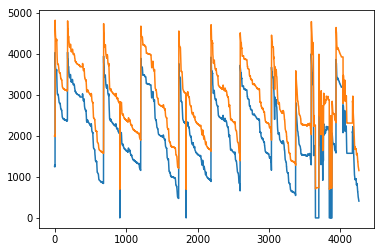

In [54]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-test_data_num:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-test_data_num:])
pyplot.plot(predictions)
pyplot.show()